In [1]:
%matplotlib inline
import os, sys, inspect, warnings
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
main_dir = '/'.join(curr_dir.split('/')[:-1])
sub_dir = os.path.join(main_dir, 'RGCPD/')
# core_pp = os.path.join(main_dir, 'RGCPD/core')
if main_dir not in sys.path:
    sys.path.append(main_dir)
    sys.path.append(sub_dir)
import numpy as np
import math
from collections import Counter
# import statsmodels.api as sm 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import itertools as it
import pywt as wv
from scipy.fftpack import fft
from copy import deepcopy
# from statsmodels.tsa.arima_process import  arma_generate_sample, ArmaProcess
from pprint import pprint as pp 
from pandas.plotting import register_matplotlib_converters
from RGCPD import RGCPD
from RGCPD import BivariateMI
from df_ana_class import DataFrameAnalysis, VisualizeAnalysis
import core_pp
import plot_signal_decomp
import plot_coeffs
from visualize_cwt import *
register_matplotlib_converters()
np.random.seed(12345)
plt.style.use('seaborn')

Could not import rpy package
Could not import r-package RCIT


In [2]:
path_data = os.path.join(main_dir, 'data')
current_analysis_path = os.path.join(main_dir, 'Jier_analysis')
target= 3
target_path = os.path.join(path_data, 'tf5_nc5_dendo_80d77.nc')
precursor_path = os.path.join(path_data,'sst_1979-2018_2.5deg_Pacific.nc')
list_of_name_path = [(target, target_path), 
                    ('sst', precursor_path )]
list_for_MI = [BivariateMI(name='sst', func=BivariateMI.corr_map, 
                          kwrgs_func={'alpha':.0001, 'FDR_control':True}, 
                          distance_eps=700, min_area_in_degrees2=5)]
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           start_end_TVdate=('06-01', '08-31'),
           path_outmain=os.path.join(main_dir,'data'))


In [3]:
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)
rg.pp_TV()
rg.traintest(method='no_train_test_split')
rg.calc_corr_maps()
rg.cluster_list_MI()
rg.get_ts_prec(precur_aggr=1)

Loaded pre-processed data of sst

original tfreq of imported response variable is converted to desired tfreq 10
Daily input freq
No train test split

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(400dp, 100%)

redefine target variable on 1 day means
Selecting subset as defined by start_end_date
Daily input freq
No train test split

Getting MI timeseries
There are [2] regions in total (list of different splits)


In [4]:
rg.dates_TV

DatetimeIndex(['1979-06-01', '1979-06-02', '1979-06-03', '1979-06-04',
               '1979-06-05', '1979-06-06', '1979-06-07', '1979-06-08',
               '1979-06-09', '1979-06-10',
               ...
               '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
               '2018-08-26', '2018-08-27', '2018-08-28', '2018-08-29',
               '2018-08-30', '2018-08-31'],
              dtype='datetime64[ns]', length=3680, freq=None)

Progress causal inference - traintest set 100%

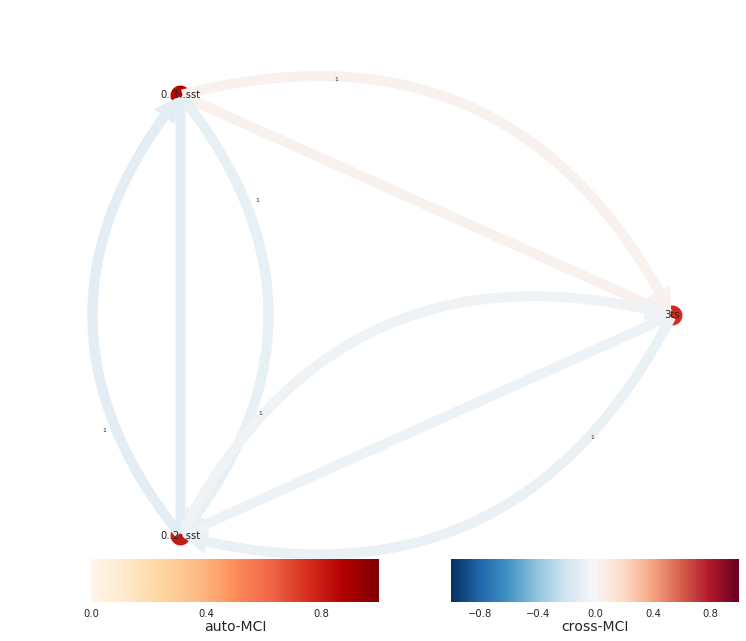

In [5]:
rg.PCMCI_df_data()
rg.PCMCI_get_links()
rg.df_MCIc
rg.PCMCI_plot_graph()

In [6]:
rg_data  = rg.df_data[['3ts', '0..1..sst', '0..2..sst']]
rg_data = rg_data.rename(columns={'0..1..sst':'prec1', '0..2..sst':'prec2'})
rg_index = rg_data.index.levels[1]
prec1 = rg_data['prec1'].values
prec2 = rg_data['prec2'].values
target = rg_data['3ts'].values
wave  = wv.Wavelet('db4')
mode=wv.Modes.periodic

In [7]:
def lowpassfilter(signal, thresh = 0.63, wavelet="haar"):
    thresh = thresh*np.nanmax(signal)
    coeff = wv.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (wv.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = wv.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal



In [8]:
def denoise_high_frequency(signal, thresh, wavelet):
    new_signal = lowpassfilter(signal, thresh, wavelet)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(signal, 'r', alpha=0.5, label='original')
    ax.legend()
    ax.plot(new_signal, 'k', alpha=0.4, label='denoised')
    ax.legend()

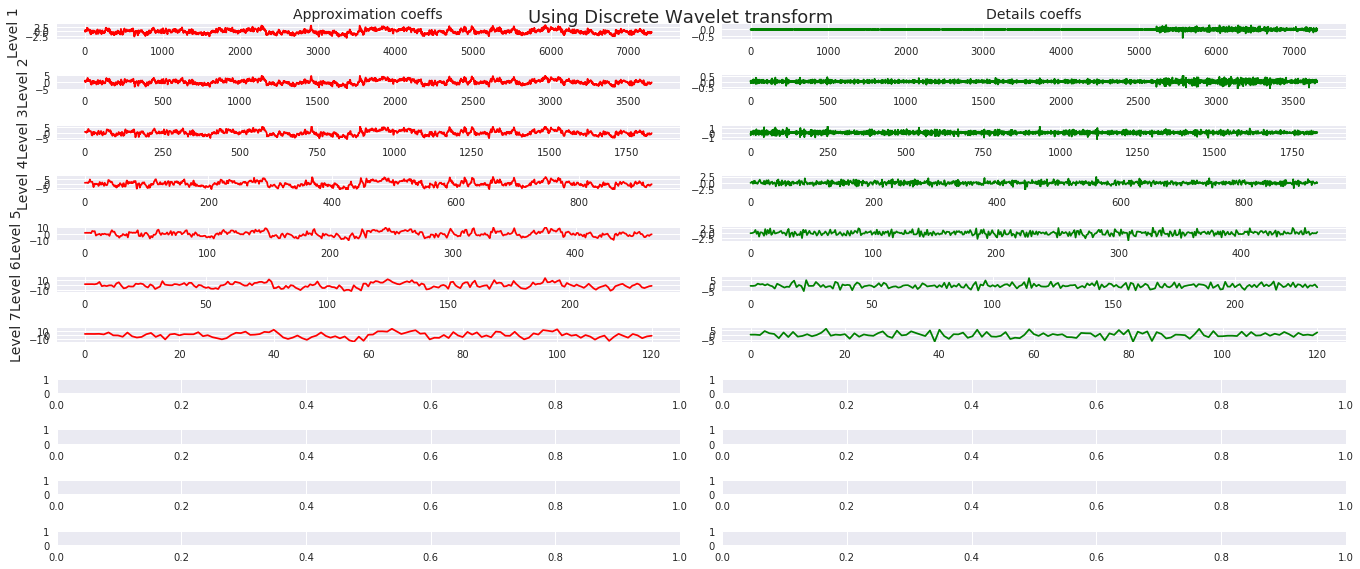

In [9]:
fig, ax = plt.subplots(11, 2, figsize=(19, 8))
fig.suptitle('Using Discrete Wavelet transform', fontsize=18)
ap = rg_data['prec1'].values
for i in range(7):
   ap, det =  wv.dwt(ap, wave)
   ax[i, 0].plot(ap, 'r')
   ax[i, 1].plot(det, 'g')
   ax[i, 0].set_ylabel('Level {}'.format(i + 1), fontsize=14, rotation=90)
   if i == 0:
        ax[i, 0].set_title('Approximation coeffs', fontsize=14)
        ax[i, 1].set_title('Details coeffs', fontsize=14)
plt.tight_layout()
plt.show()

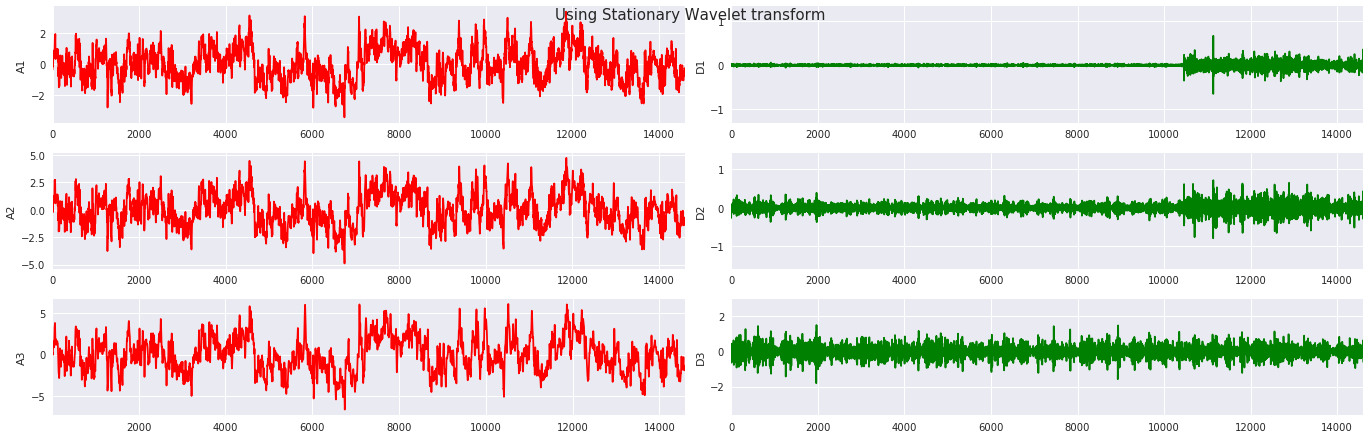

In [10]:
fig = plt.figure(figsize=(19, 8))
fig.suptitle('Using Stationary Wavelet transform', fontsize=15)
a = rg_data['prec1'].values
w  = wv.Wavelet('db4')
coeffs =  wv.swt(a, w, 3)
ca , cd = [], []
for ap, det  in reversed(coeffs):
    ca.append(ap)
    cd.append(det)
for i, x in enumerate(ca):
    ax = fig.add_subplot(len(ca) + 1, 2, 1 + i * 2)
    ax.plot(x, 'r')
    ax.set_ylabel("A%d" % (i + 1))
    ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

for i, x in enumerate(cd):
    ax = fig.add_subplot(len(cd) + 1, 2, 2 + i * 2)
    ax.plot(x, 'g')
    ax.set_ylabel("D%d" % (i + 1))
    # Scale axes
    ax.set_xlim(0, len(x) - 1)
    vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
    ax.set_ylim(min(0, 2 * min(vals)), max(0, 2 * max(vals)))
plt.tight_layout()

In [11]:
# fig = plt.figure(figsize=(19, 8))
# fig.suptitle('Using Stationary Wavelet transform', fontsize=15)
# a = rg_data['prec1'].values
# w  = wv.Wavelet('db4')
# coeffs =  wv.swt(a, w, 5,norm=True)
# ca , cd = [], []
# for ap, det  in reversed(coeffs):
#     ca.append(ap)
#     cd.append(det)
# for i, x in enumerate(ca):
#     ax = fig.add_subplot(len(ca) + 1, 2, 1 + i * 2)
#     ax.plot(x, 'r')
#     ax.set_ylabel("A%d" % (i + 1))
#     ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

# for i, x in enumerate(cd):
#     ax = fig.add_subplot(len(cd) + 1, 2, 2 + i * 2)
#     ax.plot(x, 'g')
#     ax.set_ylabel("D%d" % (i + 1))
#     # Scale axes
#     ax.set_xlim(0, len(x) - 1)
#     vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
#     ax.set_ylim(min(0, 2 * min(vals)), max(0, 2 * max(vals)))
# plt.tight_layout()

In [12]:
wv.dwt_max_level(len(prec1), wave.dec_len)

11

In [13]:
2**8 /39

6.564102564102564

# FILTERS

In [14]:
dec_lo, dec_hi, rec_lo, rec_hi = [-0.0757657147893407,-0.0296355276459541, 0.4976186676324578, 0.8037387518052163, 0.2978577956055422,-0.0992195435769354,-0.0126039672622612, 0.0322231006040713, -0.0757657147893407,-0.0296355276459541, 0.4976186676324578, 0.8037387518052163, 0.2978577956055422,-0.0992195435769354,-0.0126039672622612, 0.0322231006040713], [0.0757657147893407,
 0.0296355276459541,
 -0.4976186676324578,
 -0.8037387518052163,
 -0.2978577956055422,
 0.0992195435769354,
 0.0126039672622612,
 -0.0322231006040713,-0.0757657147893407,-0.0296355276459541, 0.4976186676324578, 0.8037387518052163, 0.2978577956055422,-0.0992195435769354,-0.0126039672622612, 0.0322231006040713 ], [-0.0757657147893407,-0.0296355276459541, 0.4976186676324578, 0.8037387518052163, 0.2978577956055422,-0.0992195435769354,-0.0126039672622612, 0.0322231006040713,-0.0757657147893407,-0.0296355276459541, 0.4976186676324578, 0.8037387518052163, 0.2978577956055422,-0.0992195435769354,-0.0126039672622612, 0.0322231006040713 ], [-0.0757657147893407,-0.0296355276459541, 0.4976186676324578, 0.8037387518052163, 0.2978577956055422,-0.0992195435769354,-0.0126039672622612, 0.0322231006040713,0.0757657147893407,
 0.0296355276459541,
 -0.4976186676324578,
 -0.8037387518052163,
 -0.2978577956055422,
 0.0992195435769354,
 0.0126039672622612,
 -0.0322231006040713 ]
filter_bank = [dec_lo, dec_hi, rec_lo, rec_hi]
# np.savez('la8_filter.npz', filter_bank=filter_bank)
la8 = wv.Wavelet(name="LA8", filter_bank=filter_bank)
la8.orthogonal = True
la8.biorthogonal = True

db4  = wv.Wavelet('db4')
db4_normalized = wv.Wavelet(
    'db4_normalized',
    filter_bank=[np.asarray(f)/np.sqrt(2) for f in db4.filter_bank]
)

db4_normalized.orthogonal = True
db4_normalized.biorthogonal = True
sym8 = wv.Wavelet('sym8')
wave =sym8

# DWT decomposition only using Details
## DB4, DB4 normalised does not capture signal well, not useful, LA8 captures it too well both peak estimation vs theoretical peak understimated 

In [15]:
# Using recursion we obtain all of our approximation coefficients with just dwt
s_prec1 = prec1
cA, cD = [], []

for i in range(wv.dwt_max_level(len(s_prec1), wave.dec_len)): # Using recursion to overwrite signal to go level deepeer
   s_prec1, det =  wv.dwt(s_prec1, wave , mode=mode)
#    print('Len Sign ', len(s_prec1), 'Lenght detail ', len(det))
   cA.append(s_prec1)
   cD.append(det)
# print('Inspecting approximations length')
# for i, c in enumerate(cA):
#     print(i, len(c))
# print('Inspecting details length')
# for i, d in enumerate(cD):
#     print(i, len(d))

s_prec2 = prec2
cA_2, cD_2 = [], []
# wave  = wv.Wavelet('db4')
for i in range(wv.dwt_max_level(len(s_prec2), wave.dec_len)): # Using recursion to overwrite signal to go level deepeer
   s_prec2, det =  wv.dwt(s_prec2, wave , mode=mode)
#    print('Len Sign ', len(s_prec2), 'Lenght detail ', len(det))
   cA_2.append(s_prec2)
   cD_2.append(det)
# print('Inspecting approximations length')
# for i, c in enumerate(cA_2):
#     print(i, len(c))
# print('Inspecting details length')
# for i, d in enumerate(cD_2):
#     print(i, len(d))

s_target = target
cA_t, cD_t = [], []
# wave  = wv.Wavelet('db4')
for i in range(wv.dwt_max_level(len(s_target), wave.dec_len)): # Using recursion to overwrite signal to go level deepeer
   s_target, det =  wv.dwt(s_target, wave , mode=mode)
#    print('Len Sign ', len(s_target), 'Lenght detail ', len(det))
   cA_t.append(s_target)
   cD_t.append(det)
# print('Inspecting approximations length')
# for i, c in enumerate(cA_t):
#     print(i, len(c))
# print('Inspecting details length')
# for i, d in enumerate(cD_t):
#     print(i, len(d))

# Reconstructed signal
## Signal causes zero division error no much difference than that

In [16]:
def create_signal_recontstruction(data, wave, level, mode=wv.Modes.periodic):
    w = wave
    assert isinstance(data, pd.Series) , f"Expect pandas Series, {type(data)} given"
    assert isinstance(w, wv.Wavelet)
    a = data
    ca = []
    cd = []
    level_ = wv.dwt_max_level(len(data), w.dec_len)
    lvl_decomp = level if level_ > level else level_
    print(f'Level decomposition {lvl_decomp}')
    for i in range(lvl_decomp):
        (a, d) = wv.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(wv.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(wv.waverec(coeff_list, w)) 

    return rec_a, rec_d

rA, rD = create_signal_recontstruction(data=rg_data['prec1'], wave=wave, level=15, mode=wv.Modes.periodic)

rA_2, rD_2 = create_signal_recontstruction(data=rg_data['prec2'], wave=wave, level=15, mode=wv.Modes.periodic)

rA_t, rD_t = create_signal_recontstruction(data=rg_data['3ts'], wave=wave, level=15, mode=wv.Modes.periodic)

Level decomposition 9
Level decomposition 9
Level decomposition 9


# MODWT DEFAULT
## Do not use for analysis in MCI, too few levels in default mode, too many data in extended mode for deeper levels

In [17]:
def get_pad_width(data):
    x  = np.log2(len(data))
    x = math.ceil(x) 
    diff = 2**x - len(data)
    return diff//2

def get_pad_data(data):
    pad_width = get_pad_width(data)
    return np.pad(data, pad_width=pad_width, mode='symmetric')

In [18]:
a = rg_data['prec1'].values
a = get_pad_data(a)
w  = sym8
# level_ = wv.swt_max_level(len(a))
level_= 6
coeffs =  wv.swt(a, w, level=level_, trim_approx=True, norm=True)
mcD = coeffs[1:]
b = rg_data['prec2'].values
b = get_pad_data(b)
# w  = la8
level_ = wv.swt_max_level(len(b))

coeffs =  wv.swt(b, w, level=level_, trim_approx=True, norm=True)
mcD_2 = coeffs[1:]
c = rg_data['3ts'].values
c = get_pad_data(c)
# w  = la8
level_ = wv.swt_max_level(len(c))

coeffs =  wv.swt(c, w, level=level_, trim_approx=True, norm=True)
mcD_t = coeffs[1:]

# MCI Target vs Prec1

Progress causal inference - traintest set 100%

/home/jier/miniconda3/envs/RGCPD/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


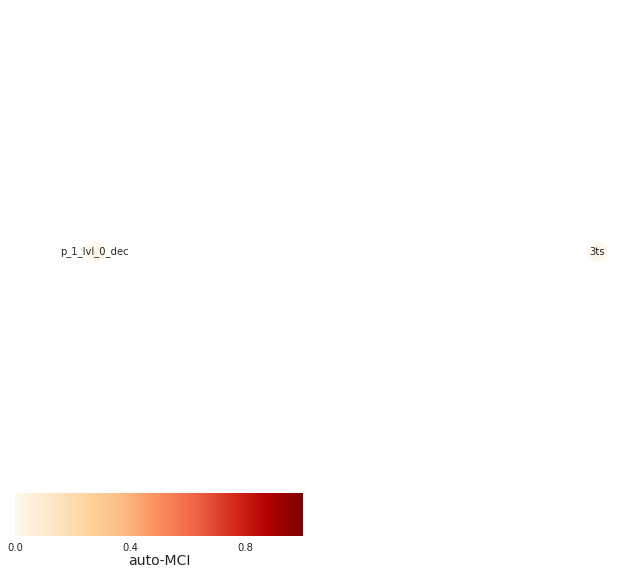

Progress causal inference - traintest set 100%

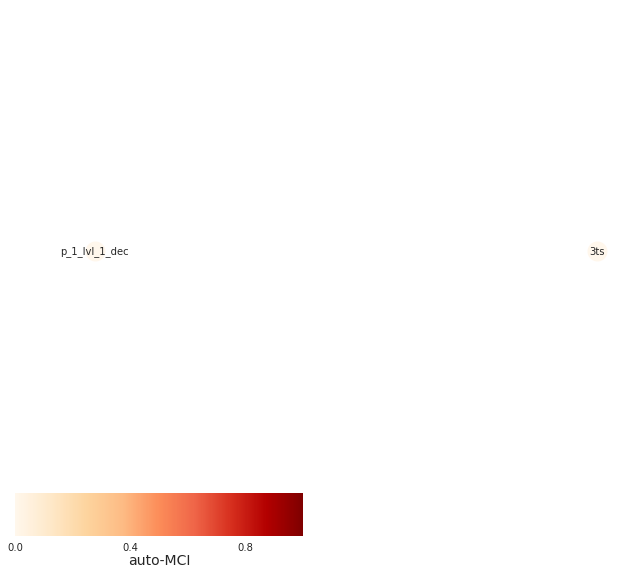

Progress causal inference - traintest set 100%

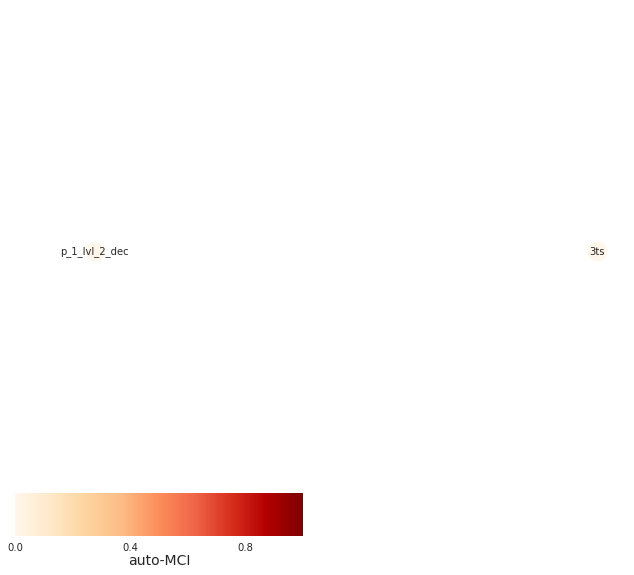

Progress causal inference - traintest set 100%

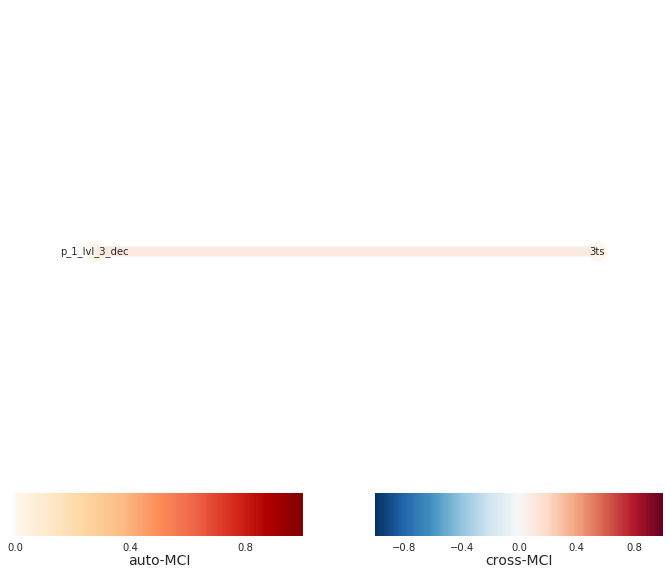

Progress causal inference - traintest set 100%

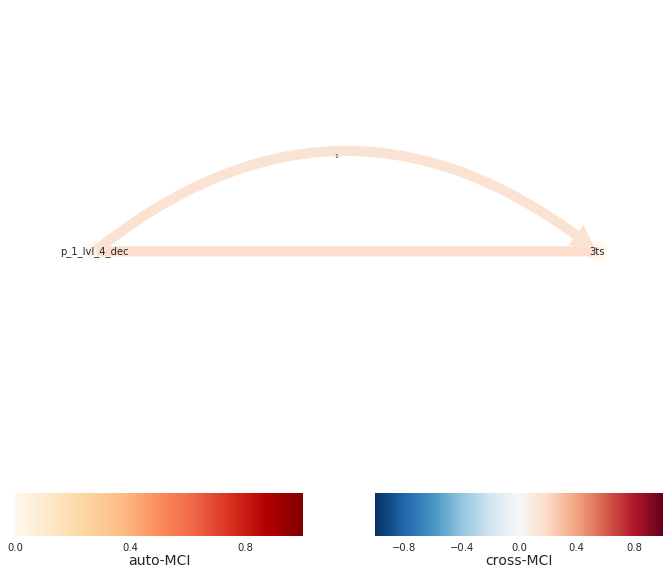

Progress causal inference - traintest set 100%

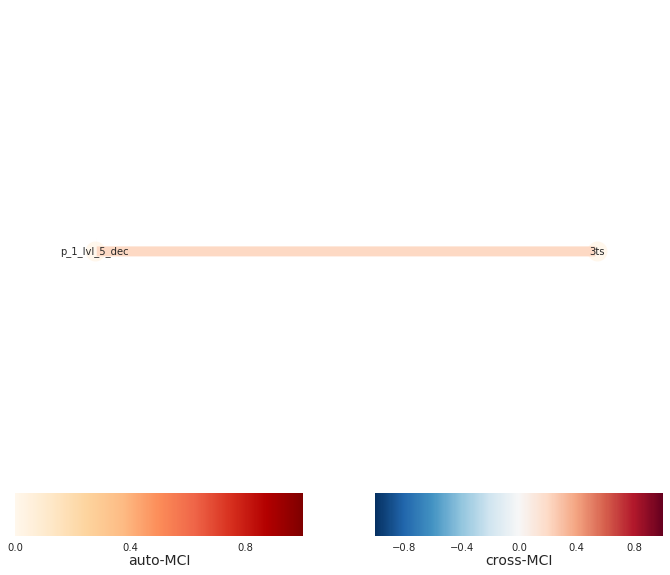

Progress causal inference - traintest set 100%

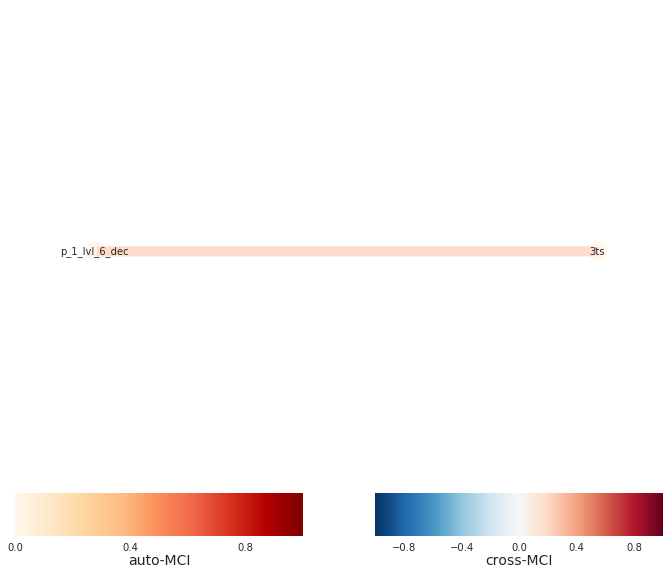

Progress causal inference - traintest set 100%

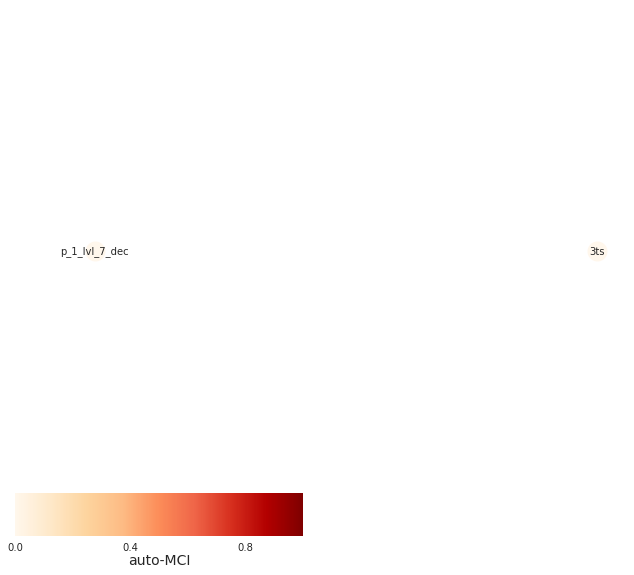

Progress causal inference - traintest set 100%

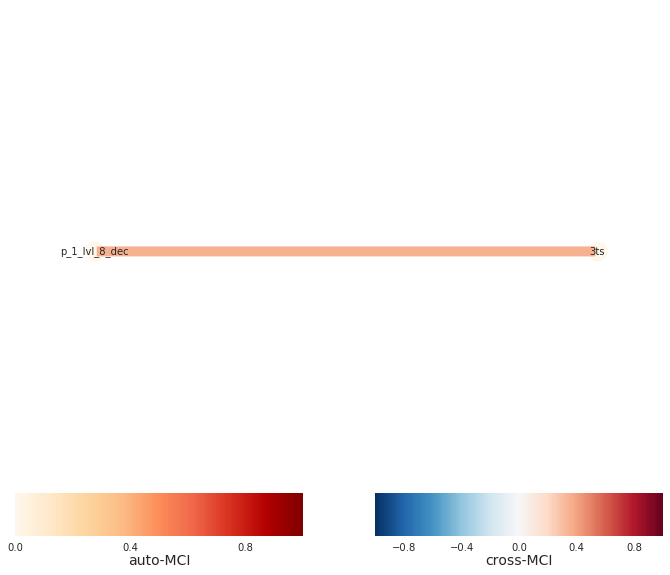

In [19]:
obj_rgcpd = []
# cD = rD
# cD_t = rD_t
# cD = mcD
# cD_t = mcD_t
for i in range(0,len(cD)):    
    idx_lvl_t = pd.DatetimeIndex(pd.date_range(rg_index[0] ,rg_index[-1], periods=len(cD_t[i]) ).strftime('%Y-%m-%d') )
#     print((idx_lvl_t[1] - idx_lvl_t[0]).days, )
#     sys.exit()
    idx_prec = pd.DatetimeIndex(pd.date_range(rg_index[0], rg_index[-1], periods=len(cD_t[i]) ).strftime('%Y-%m-%d') )
    dates = core_pp.get_subdates(dates=idx_lvl_t, start_end_date=('06-01', '08-31'), start_end_year=None, lpyr=False)
    full_time  = idx_lvl_t
    RV_time  = dates
    RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='RV_mask')
    trainIsTrue = pd.Series(np.array([True for _ in range(len(cD_t[i]))]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='TrainIsTrue')
    ts_ca1 = pd.Series(cD[i], index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_1_lvl_'+ str(i)+'_dec')
    # ts_ca2= pd.Series(cA_2[i], index=pd.MultiIndex.from_product(([0], idx_prec)), name='p_2_lvl_'+str(i)+'_dec')
    ts_tca1 = pd.Series(cD_t[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
    df = pd.concat([ts_tca1, ts_ca1, trainIsTrue, RV_mask], axis=1)
    rg.df_data = df
    rg.PCMCI_df_data()
    rg.PCMCI_get_links()
    rg.df_MCIc
    obj_rgcpd.append(deepcopy(rg.df_MCIc))
    rg.PCMCI_plot_graph()

In [20]:
clean_mci = obj_rgcpd
lag_0 = [np.mean(lags.values[:,0]) for i, lags in enumerate(clean_mci)]
lag_1 = [np.mean(lags.values[:,1]) for _, lags in enumerate(clean_mci)]

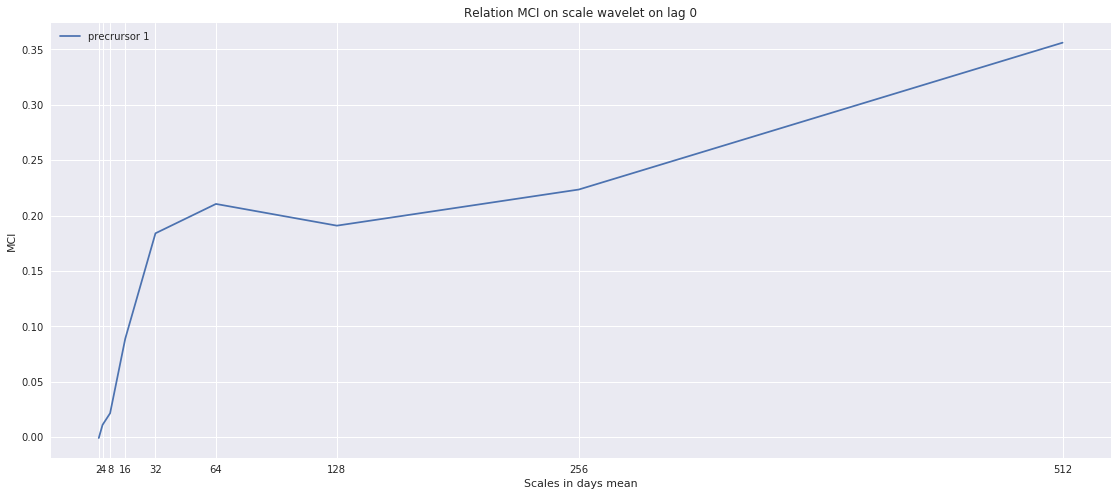

In [21]:
# lag_0_t = [lags.values[:,0][0] for _, lags in enumerate(clean_mci)]


x_as = np.arange(1, len(cD)+1 )
x_as = np.exp2(x_as)
lag_0_1 = [lags.values[:,0][1] for _, lags in enumerate(obj_rgcpd)]

plt.figure(figsize=(19,8))
# plt.plot(x_as, lag_0_t, label='target ')
plt.xticks(x_as)
plt.plot(x_as, lag_0_1, label='precrursor 1 ')
plt.title('Relation MCI on scale wavelet on lag 0')
plt.xlabel('Scales in days mean')
plt.ylabel('MCI')
plt.legend(loc=0)
plt.show()

In [22]:
# lag_1_t = [lags.values[:,1][0] for _, lags in enumerate(clean_mci)]
# lag_1_1 = [lags.values[:,1][1] for _, lags in enumerate(clean_mci)]
# plt.figure(figsize=(19,8))
# plt.plot(x_as, lag_1_t, label='target ')
# plt.plot(x_as, lag_1_1, label='precrursor 1 ')
# plt.title('Relation MCI on scale wavelet on lag 1')
# plt.xlabel('Scales')
# plt.ylabel('MCI')
# plt.legend(loc=0)
# plt.show()

# MCI Target vs Prec2

Progress causal inference - traintest set 100%

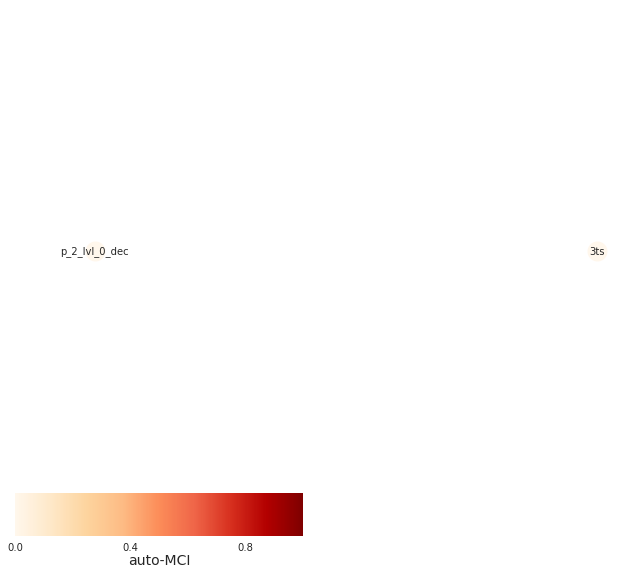

Progress causal inference - traintest set 100%

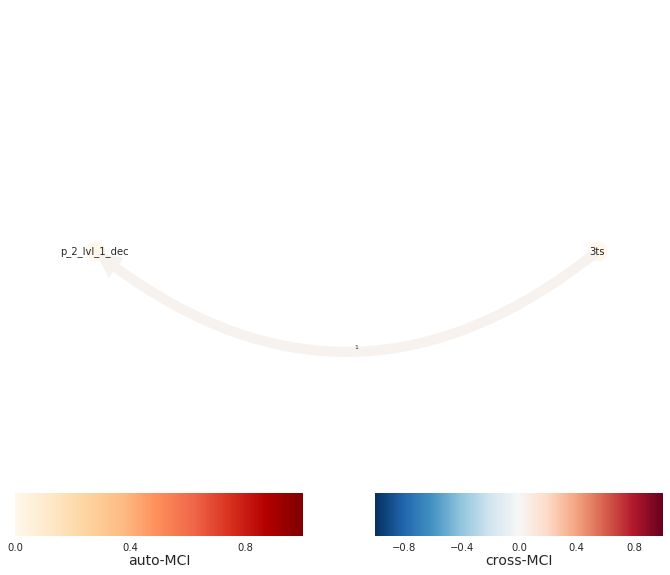

Progress causal inference - traintest set 100%

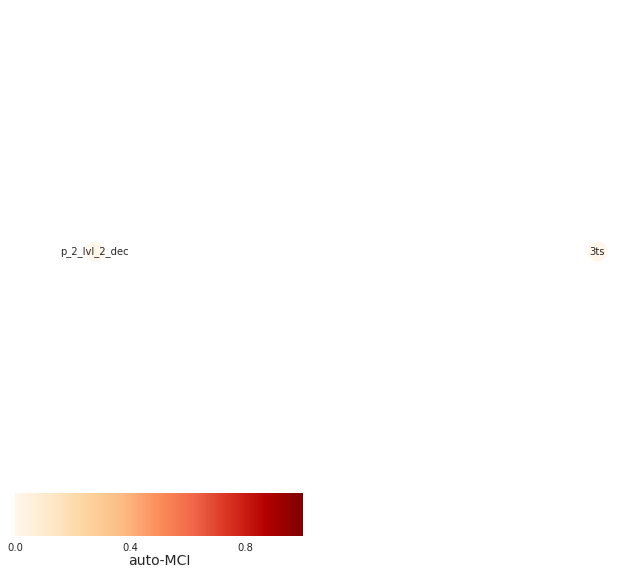

Progress causal inference - traintest set 100%

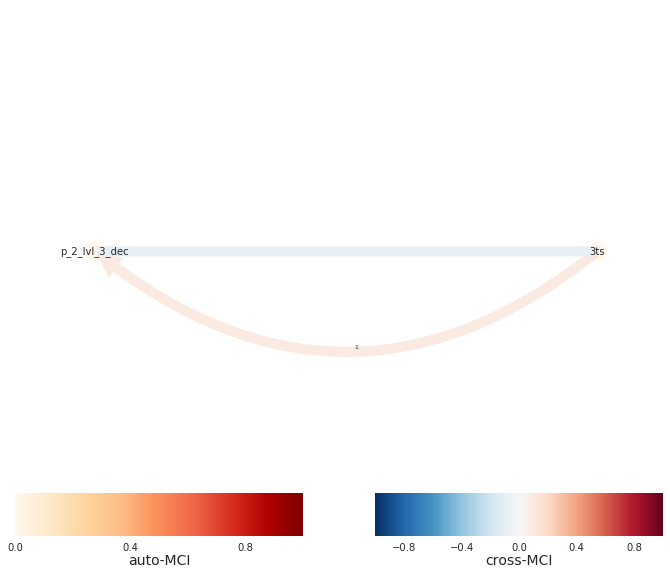

Progress causal inference - traintest set 100%

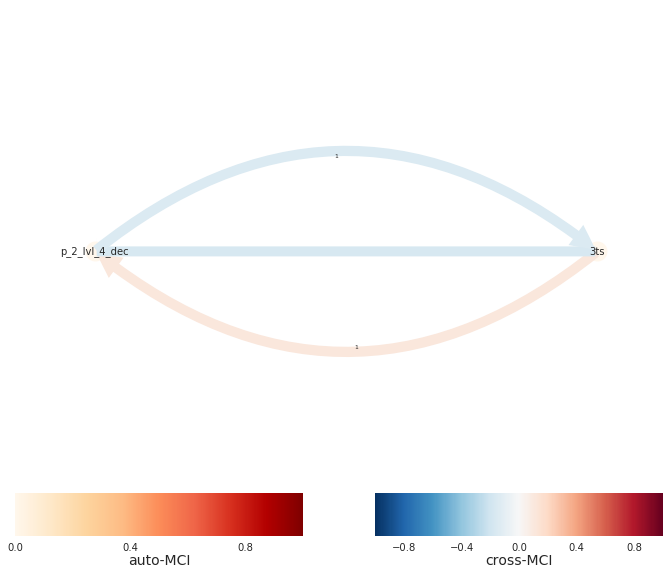

Progress causal inference - traintest set 100%

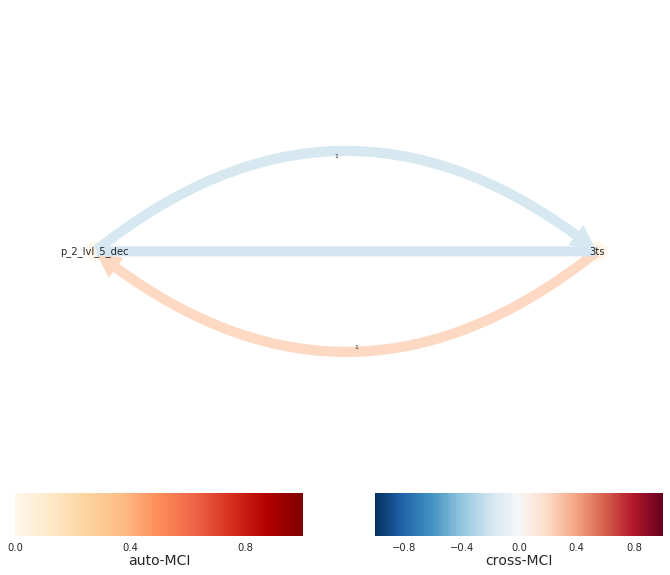

Progress causal inference - traintest set 100%

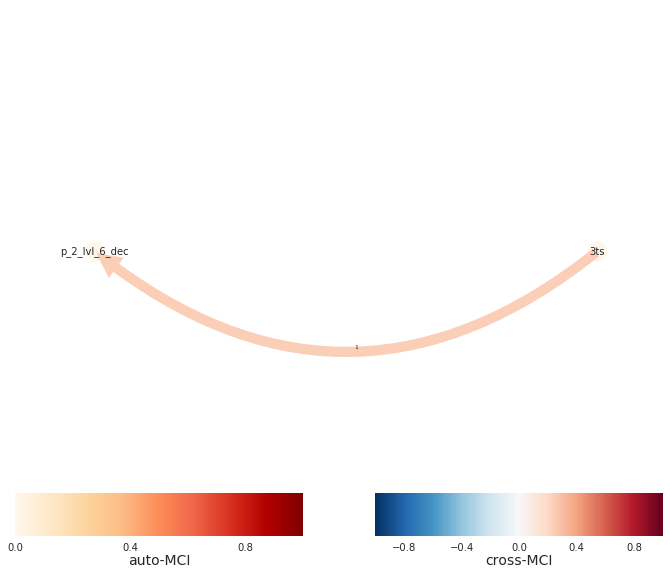

Progress causal inference - traintest set 100%

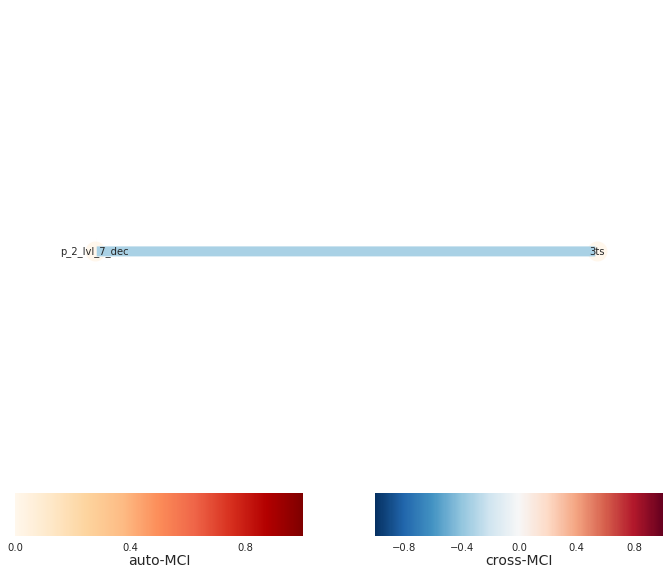

Progress causal inference - traintest set 100%

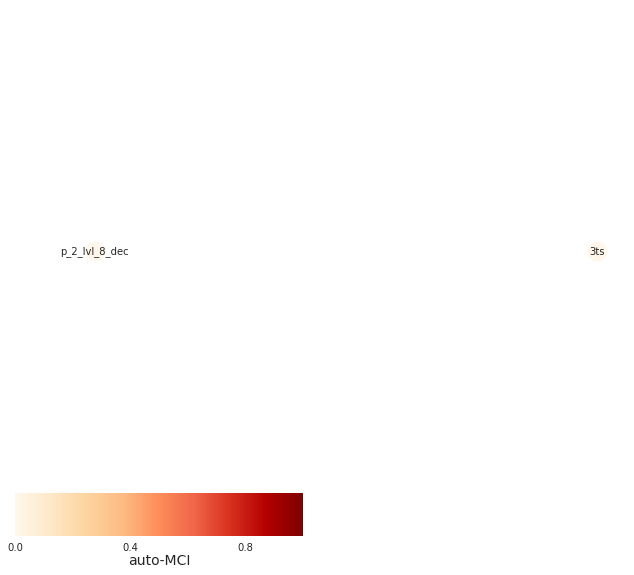

In [23]:
obj_r = []
# cD_2= rD_2
# cD_t = rD_t
for i in range(0,len(cD_2)):    
    idx_lvl_t = pd.DatetimeIndex(pd.date_range(rg_index[0] ,rg_index[-1], periods=len(cD_t[i]) ).strftime('%Y-%m-%d') )
    idx_prec = pd.DatetimeIndex(pd.date_range(rg_index[0], rg_index[-1], periods=len(cD_2[i]) ).strftime('%Y-%m-%d') )
    dates = core_pp.get_subdates(dates=idx_lvl_t, start_end_date=('06-01', '08-31'), start_end_year=None, lpyr=False)
    full_time  = idx_lvl_t
    RV_time  = dates
    RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='RV_mask')
    trainIsTrue = pd.Series(np.array([True for _ in range(len(cD_t[i]))]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='TrainIsTrue')
    # ts_ca1 = pd.Series(cA[i], index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_1_lvl_'+ str(i)+'_dec')
    ts_ca2= pd.Series(cD_2[i], index=pd.MultiIndex.from_product(([0], idx_prec)), name='p_2_lvl_'+str(i)+'_dec')
    ts_tca1 = pd.Series(cD_t[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
    df = pd.concat([ts_tca1, ts_ca2, trainIsTrue, RV_mask], axis=1)
    rg.df_data = df
    rg.PCMCI_df_data()
    rg.PCMCI_get_links()
    rg.df_MCIc
    obj_r.append(deepcopy(rg.df_MCIc))
    rg.PCMCI_plot_graph()

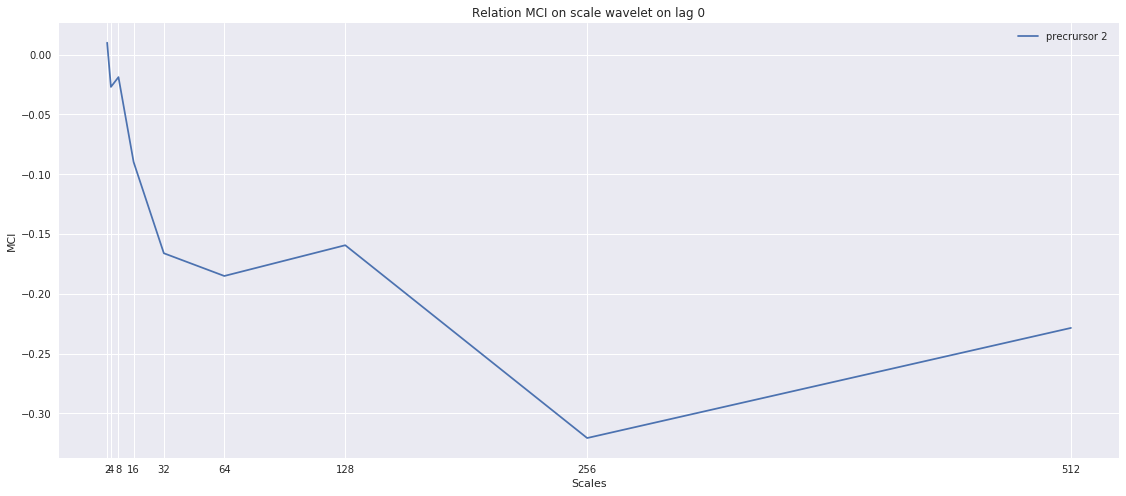

In [24]:
# lag_0_t = [lags.values[:,0][0] for _, lags in enumerate(obj_r)]
lag_0_1 = [lags.values[:,0][1] for _, lags in enumerate(obj_r)]
x_as = np.arange(1, len(cD_2)+1)
x_as = np.exp2(x_as)
plt.figure(figsize=(19,8))
# plt.plot(x_as, lag_0_t, label='target ')
plt.xticks(x_as)
plt.plot(x_as, lag_0_1, label='precrursor 2 ')
plt.title('Relation MCI on scale wavelet on lag 0')
plt.xlabel('Scales')
plt.ylabel('MCI')
plt.legend(loc=0)
plt.show()

# Theoretical vs Experimental freq SST time

In [25]:
print(f'Experimental time given 39 years of data {256/39} years vs approximately {10} years out of expert knowledge')

Experimental time given 39 years of data 6.564102564102564 years vs approximately 10 years out of expert knowledge


In [26]:
print(f'Peak further than 10 years approx SST pattern namely {512/39} years')

Peak further than 10 years approx SST pattern namely 13.128205128205128 years


In [27]:
print(f'Peak too far lower bound of expected approximate 10 years, namely {128/39} years')

Peak too far lower bound of expected approximate 10 years, namely 3.282051282051282 years


In [28]:
print(f'Peak too far above bound of expected approximate 10 years, namely, {1024/39} years')

Peak too far above bound of expected approximate 10 years, namely, 26.256410256410255 years


# Visualize Power spectrum of peak in level of Details coeff

In [29]:
da = DataFrameAnalysis()
dv = VisualizeAnalysis()

Initiate DFA ANA
DFA ANA
initiate vision
Vision


In [31]:
index = pd.DatetimeIndex(pd.date_range(rg_index[0] ,rg_index[-1], periods=len(cD[8]) ).strftime('%Y-%m-%d'))
d = {'prec1': cD[8], 'prec2':cD_2[8], 'target':cD_t[8]}
df = pd.DataFrame(data=d, index=index)

In [32]:
df.columns.tolist()

['prec1', 'prec2', 'target']

In [51]:
result, freqdf, freq, idx_ = da.spectrum(df, {'periodogram': da.periodogram})

In [52]:
nice_colors = ['#EE6666', '#3388BB', '#9988DD',
            '#EECC55', '#88BB44', '#FFBBBB']

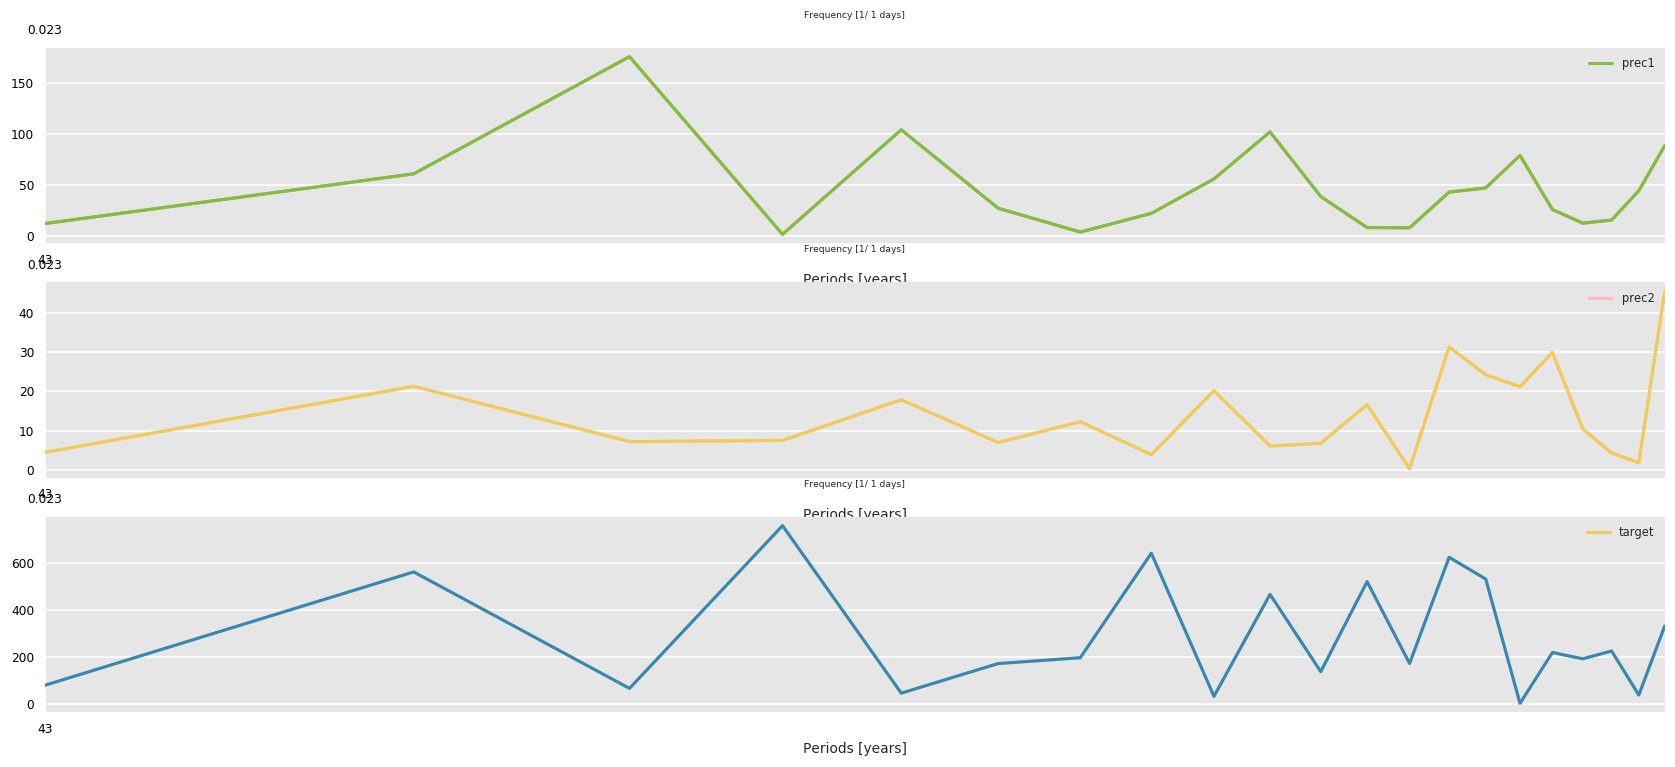

In [54]:
fig,ax = plt.subplots(len(d), 1, figsize=(19, 8), dpi=110)
for  key, values in result.items():
    for idx, v in enumerate(df.columns.tolist()):
        ax[idx].plot(values[0][idx], values[1][idx], ls='-',c =np.random.choice(nice_colors), label=v)
        ax[idx].set_xscale('log')
        ax[idx].set_xticks(values[0][idx][np.logical_or(values[0][idx] % 2 == 0, values[0][idx] % 1 == 0)])
        ax[idx].set_xticklabels(np.array(values[0][idx][np.logical_or(values[0][idx] % 2 == 0, values[0][idx] % 1 == 0)], dtype=int))
        ax[idx].set_xlim((values[0][idx][0], values[0][idx][-1]))

        ax[idx].set_xlabel('Periods [years]', fontsize=9)
        ax[idx].tick_params(axis='both', labelsize=8)

        ax2 = ax[idx].twiny()
        ax2.plot(values[0][idx], values[1][idx], ls='-',c =np.random.choice(nice_colors), label=v)
        ax2.set_xscale('log')
        ax2.set_xticks(values[0][idx][np.logical_or(values[0][idx] % 2 == 0, values[0][idx] % 1 == 0)])
        ax2.set_xticklabels(np.round(freq[idx][1:idx_[idx] + 2][np.logical_or(values[0][idx] % 2 == 0, values[0][idx] % 1 == 0)], 3))
        ax2.set_xlim((values[0][idx][0], values[0][idx][-1])) 
        ax2.tick_params(axis='both', labelsize=8)
        if freqdf == 'month':
            ax2.set_xlabel('Frequency [1 /months]', fontsize=6)
        else:
            ax2.set_xlabel(f'Frequency [1/ {freqdf} days]', fontsize=6)
        ax[idx].legend(loc=0, fontsize='xx-small')
plt.show()

In [35]:
# GRRR Weird plot of df ana does not want to plot
# dv.vis_spectrum(title='Periodogram peak', subtitle=df.columns.tolist() ,results=result, freqdf=freq_df, freq=freq, idx_=idx )
# plt.show()

# Up sampling coefficients

In [ ]:
# def upcoef_approx(approx, wave, take_size):
#     return [wv.upcoef('a', app,wave, level=i+1, take=take_size) for i, app in enumerate(approx)]
# up_ca1 = upcoef_approx(cA, wave, take_size=len(prec1))
# up_ca2 = upcoef_approx(cA_2, wave, take_size=len(prec2))
# up_tar = upcoef_approx(cA_t, wave, take_size=len(target))

# Filtering per scale

In [ ]:
# def filter_per_scale(signal, wave, alpha,  boundary, mode): # Filtering all subsequent signals
#     s_sign = signal 
#     cA = []
#     cD = []
#     thresh =  alpha * np.nanmax(signal)
#     for i in range(wv.dwt_max_level(len(s_sign), wave.dec_len)): # Using recursion to overwrite signal to go level deepeer
#        s_sign, det =  wv.dwt(s_sign, wave , mode=boundary)
#        s_sign = wv.threshold(s_sign, value=thresh, mode=mode)
#        det = wv.threshold(det, value=(np.nanmax(det) - np.nanmin(det))-np.nanmax(det), mode=mode)
#        cA.append(s_sign)
#        cD.append(det)
#     return cA, cD

In [ ]:
# Makes dependant on either variable when filtering original signal or filtering all signals at all resulting in only small peak
# cA, cD = filter_per_scale(prec1, wave=wave, alpha=0.1, boundary='per', mode='soft') 
# cA_2, cD2 = filter_per_scale(prec2, wave=wave, alpha=0.6,  boundary='per', mode='soft')
# cA_t, cDt = filter_per_scale(target, wave=wave, alpha=0.6, boundary='per', mode='soft')
# fig, ax = plt.subplots(len(cA), 2, figsize=(19, 8))
# fig.suptitle('Using Discrete Wavelet transform', fontsize=18)

# for i in range(len(cA)):
#    ax[i, 0].plot(cA[i], 'r')
#    ax[i, 1].plot(cD[i], 'g')
#    ax[i, 0].set_ylabel('Level {}'.format(i + 1), fontsize=14, rotation=90)
#    if i == 0:
#         ax[i, 0].set_title('Approximation coeffs', fontsize=14)
#         ax[i, 1].set_title('Details coeffs', fontsize=14)
# plt.tight_layout()
# plt.show()

In [ ]:
# def filter_per_scale_stat(signal, wave,alpha, mode): # Filtering all subsequent signals
#     cA = []
#     cD = []
#     coeffs = wv.swt(signal, wave, level=5, norm=True)
#     for ap,  det in reversed(coeffs):
#         cA.append(ap)
#         cD.append(det)
#     thresh = alpha * np.nanmax(signal)
#     cA = [wv.threshold(i, value=thresh, mode=mode) for i in cA]
#     cD = [wv.threshold(i, value=thresh, mode=mode) for i in cD]
#     return cA, cD

In [ ]:
# ca, cd = filter_per_scale_stat(target, wave=wave,alpha=0.1, mode='soft')
# fig = plt.figure(figsize=(19, 8))
# fig.suptitle('Using Stationary Wavelet transform', fontsize=15)
# w  = wave
# for i, x in enumerate(ca):
#     ax = fig.add_subplot(len(ca) + 1, 2, 1 + i * 2)
#     ax.plot(x, 'r')
#     ax.set_ylabel("A%d" % (i + 1))
#     ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

# for i, x in enumerate(cd):
#     ax = fig.add_subplot(len(cd) + 1, 2, 2 + i * 2)
#     ax.plot(x, 'g')
#     ax.set_ylabel("D%d" % (i + 1))
#     # Scale axes
#     ax.set_xlim(0, len(x) - 1)
#     vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
#     ax.set_ylim(min(0, 2 * min(vals)), max(0, 2 * max(vals)))
# # plt.tight_layout()
# plt.plot()